In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import seaborn as sns
from scipy.stats import chi2_contingency, ttest_rel, wilcoxon
import statsmodels.api as sm

# Load the dataset
file_path = 'data.xlsx'
data = pd.read_excel(file_path)




In [2]:
# Select relevant columns
columns = ['sex', 'age', 'hours_to_hospital', 'kts', 'initialdec', 'mechofinj_str']
data = data[columns]

# Convert 'sex' to categorical
data['sex'] = data['sex'].map({1: 'Male', 2: 'Female'}).fillna('Unknown')

# Convert 'initial_dec' to categorical with appropriate labels
data['initialdec'] = data['initialdec'].map({
    1: 'Treat and send home',
    2: 'Take to theatre',
    3: 'N/A (died)',
    4: 'Admit to hospital ward'
}).fillna('Unknown')

# Filter out 'Send to' and 'Unknown' from 'initialdec'
data = data[~data['initialdec'].isin(['Send to', 'Unknown'])]

# Ensure no NaN values remain in categorical columns
data['sex'] = data['sex'].astype(str).fillna('Unknown')
data['mechofinj_str'] = data['mechofinj_str'].astype(str).fillna('Unknown')



In [3]:
# Select features and target variable
features = ['age', 'sex', 'hours_to_hospital', 'mechofinj_str']
target = 'initialdec'

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), ['age', 'hours_to_hospital']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['sex', 'mechofinj_str'])
    ])

# Split data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the pipeline for each classifier
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100),
    'Support Vector Machine': SVC(probability=True)
}

results = []
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}

In [4]:


# Train and evaluate classifiers
for name, clf in classifiers.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', clf)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    # Compute ROC curve and ROC area for each classifier
    y_test_bin = label_binarize(y_test, classes=pipeline.classes_)
    y_pred_prob = pipeline.predict_proba(X_test)
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)

    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    roc_auc_dict[name] = roc_auc

    results.append((name, accuracy, precision, recall, f1_score, roc_auc))
    
    print(f'Classifier: {name}')
    print('Accuracy:', accuracy)
    print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
    print('Classification Report:\n', classification_report(y_test, y_pred))
    print('-'*30)

Classifier: Logistic Regression
Accuracy: 0.6300914380714879
Confusion Matrix:
 [[  5   1   0   1]
 [  0 156   5  93]
 [  0   3 320 107]
 [  0  66 169 277]]
Classification Report:
                         precision    recall  f1-score   support

Admit to hospital ward       1.00      0.71      0.83         7
            N/A (died)       0.69      0.61      0.65       254
       Take to theatre       0.65      0.74      0.69       430
   Treat and send home       0.58      0.54      0.56       512

              accuracy                           0.63      1203
             macro avg       0.73      0.65      0.68      1203
          weighted avg       0.63      0.63      0.63      1203

------------------------------
Classifier: Random Forest
Accuracy: 0.6492103075644223
Confusion Matrix:
 [[  6   1   0   0]
 [  0 152   6  96]
 [  0   5 333  92]
 [  0  79 143 290]]
Classification Report:
                         precision    recall  f1-score   support

Admit to hospital ward       1.00

In [5]:

# Determine the model with the highest accuracy
best_model = max(results, key=lambda x: x[1])
print(f'Best Model: {best_model}')

# Create a table for the results
results_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC'])
print(results_df)



Best Model: ('Gradient Boosting', 0.684123025768911, 0.6827546917423729, 0.684123025768911, 0.6791341980856858, 0.9116628397603019)
               Classifier  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0     Logistic Regression  0.630091   0.629736  0.630091  0.627832  0.893741
1           Random Forest  0.649210   0.646388  0.649210  0.646465  0.891988
2       Gradient Boosting  0.684123   0.682755  0.684123  0.679134  0.911663
3  Support Vector Machine  0.644223   0.646042  0.644223  0.642318  0.881300


<Figure size 640x480 with 0 Axes>

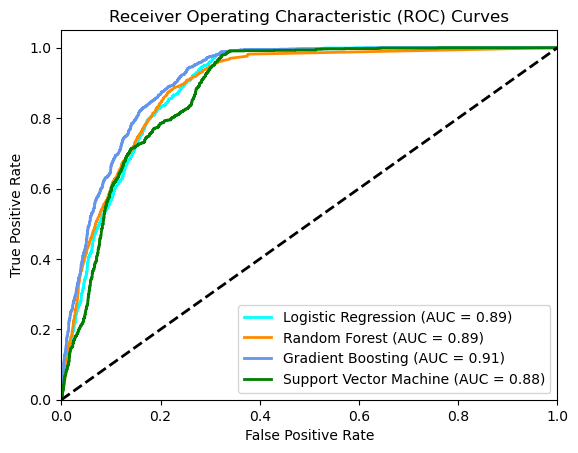

In [6]:
# Plotting the ROC curves
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])


for (name, color) in zip(classifiers.keys(), colors):
    plt.plot(fpr_dict[name], tpr_dict[name], color=color, lw=2, label=f'{name} (AUC = {roc_auc_dict[name]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [7]:


# Analyze relationship between KTS and admission decision
contingency_table = pd.crosstab(data['kts'], data['initialdec'])
chi2, p, dof, expected = chi2_contingency(contingency_table)
print("Chi-squared Test:")
print(f"Chi2: {chi2}, p-value: {p}")



Chi-squared Test:
Chi2: 243.66248788713608, p-value: 2.9666614232860466e-38


In [8]:
# Convert 'initialdec' to numerical categories for logistic regression
data['initialdec_num'] = data['initialdec'].map({
    'Treat and send home': 0,
    'Take to theatre': 1,
    'N/A (died)': 2,
    'Admit to hospital ward': 3
})

# Drop rows with NaN values in 'kts' or 'initialdec_num'
data_clean = data.dropna(subset=['kts', 'initialdec_num'])

# Define the predictor and response variables for multinomial logistic regression
X_kts_logit_clean = sm.add_constant(data_clean['kts'])  # Add constant term for intercept
y_initialdec_logit_clean = data_clean['initialdec_num']

# Fit the multinomial logistic regression model
mnlogit_model_kts_clean = sm.MNLogit(y_initialdec_logit_clean, X_kts_logit_clean)
result_mnlogit_kts_clean = mnlogit_model_kts_clean.fit()

# Print the summary of the multinomial logistic regression model
print(result_mnlogit_kts_clean.summary())

# Predict probabilities using the fitted model
y_pred_probs_kts = result_mnlogit_kts_clean.predict(X_kts_logit_clean)
y_pred_kts = y_pred_probs_kts.idxmax(axis=1)

# Calculate accuracy, precision, recall, and F1-score for KTS model
accuracy_kts = accuracy_score(y_initialdec_logit_clean, y_pred_kts)
precision_kts, recall_kts, f1_score_kts, _ = precision_recall_fscore_support(y_initialdec_logit_clean, y_pred_kts, average='weighted')

# Since ROC AUC is for binary/multiclass classification, use OneVsRest for multiclass
y_initialdec_bin = label_binarize(y_initialdec_logit_clean, classes=[0, 1, 2, 3])
roc_auc_kts = roc_auc_score(y_initialdec_bin, y_pred_probs_kts, multi_class='ovr')

print(f'KTS Model - Accuracy: {accuracy_kts}, Precision: {precision_kts}, Recall: {recall_kts}, F1-Score: {f1_score_kts}, AUC-ROC: {roc_auc_kts}')


Optimization terminated successfully.
         Current function value: 0.986061
         Iterations 9
                          MNLogit Regression Results                          
Dep. Variable:         initialdec_num   No. Observations:                 2095
Model:                        MNLogit   Df Residuals:                     2089
Method:                           MLE   Df Model:                            3
Date:                Thu, 01 Aug 2024   Pseudo R-squ.:                 0.03154
Time:                        13:18:51   Log-Likelihood:                -2065.8
converged:                       True   LL-Null:                       -2133.1
Covariance Type:            nonrobust   LLR p-value:                 5.612e-29
initialdec_num=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.1997      0.692      8.965      0.000       4.844       7.555
kts        

/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Create a DataFrame for the KTS model performance
kts_results = pd.DataFrame({
    'Classifier': ['KTS Score'],
    'Accuracy': [accuracy_kts],
    'Precision': [precision_kts],
    'Recall': [recall_kts],
    'F1-Score': [f1_score_kts],
    'AUC-ROC': [roc_auc_kts]
})

# Concatenate the results DataFrame with the KTS results
results_df = pd.concat([results_df, kts_results], ignore_index=True)
print(results_df)


               Classifier  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0     Logistic Regression  0.630091   0.629736  0.630091  0.627832  0.893741
1           Random Forest  0.649210   0.646388  0.649210  0.646465  0.891988
2       Gradient Boosting  0.684123   0.682755  0.684123  0.679134  0.911663
3  Support Vector Machine  0.644223   0.646042  0.644223  0.642318  0.881300
4               KTS Score  0.535084   0.423971  0.535084  0.454179  0.628612


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_fscore_support, roc_auc_score, precision_score, recall_score, f1_score
# Statistical Tests to Compare Models
# Define a function to calculate metrics for each model
def calculate_metrics(model, X, y_true):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

# Retrieve the trained Gradient Boosting model from the classifiers dictionary
gradient_boosting_model = classifiers['Gradient Boosting']

# Prepare the data for the ML model
X_test_ml = preprocessor.transform(X_test)
y_test_ml = y_test.copy()

# Calculate metrics for ML model (using Gradient Boosting as an example)
metrics_ml = calculate_metrics(gradient_boosting_model, X_test_ml, y_test_ml)

# Combine metrics into arrays for statistical tests
metrics_ml_array = np.array(metrics_ml)
metrics_kts_array = np.array([accuracy_kts, precision_kts, recall_kts, f1_score_kts])

# Perform paired t-test
t_stat, p_value_t = ttest_rel(metrics_ml_array, metrics_kts_array)
print(f'Paired t-test p-value: {p_value_t}')

# Perform Wilcoxon signed-rank test
w_stat, p_value_w = wilcoxon(metrics_ml_array, metrics_kts_array)
print(f'Wilcoxon signed-rank test p-value: {p_value_w}')

# Summary of Results
print("\nSummary of Model Performance:")
print(results_df)



Paired t-test p-value: 0.005834691064489167
Wilcoxon signed-rank test p-value: 0.125

Summary of Model Performance:
               Classifier  Accuracy  Precision    Recall  F1-Score   AUC-ROC
0     Logistic Regression  0.630091   0.629736  0.630091  0.627832  0.893741
1           Random Forest  0.649210   0.646388  0.649210  0.646465  0.891988
2       Gradient Boosting  0.684123   0.682755  0.684123  0.679134  0.911663
3  Support Vector Machine  0.644223   0.646042  0.644223  0.642318  0.881300
4               KTS Score  0.535084   0.423971  0.535084  0.454179  0.628612


/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


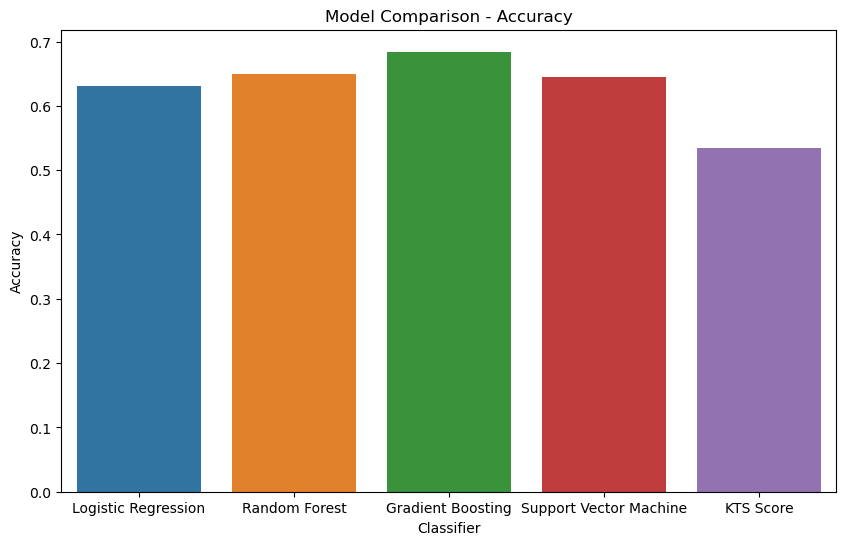

/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


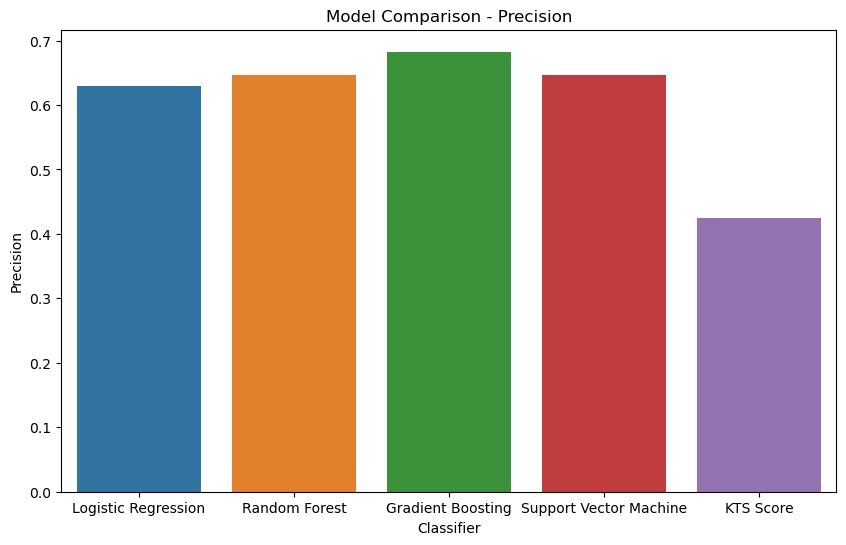

/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


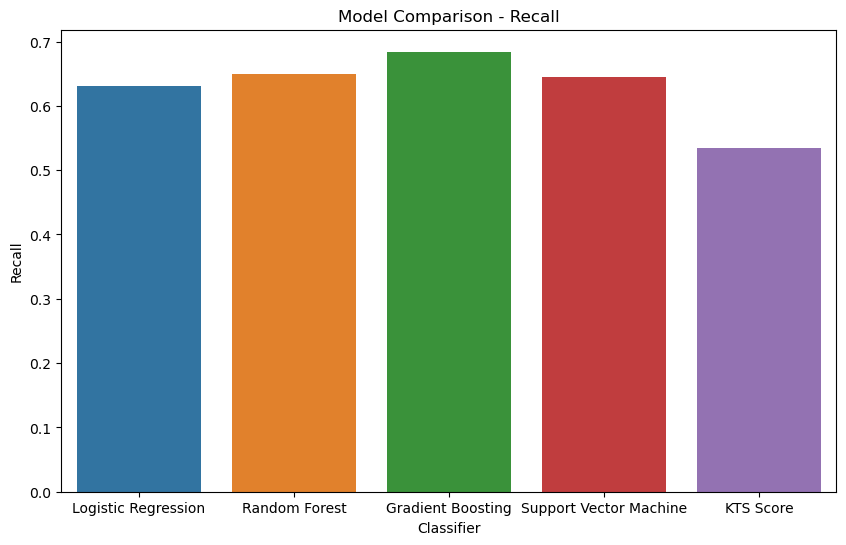

/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


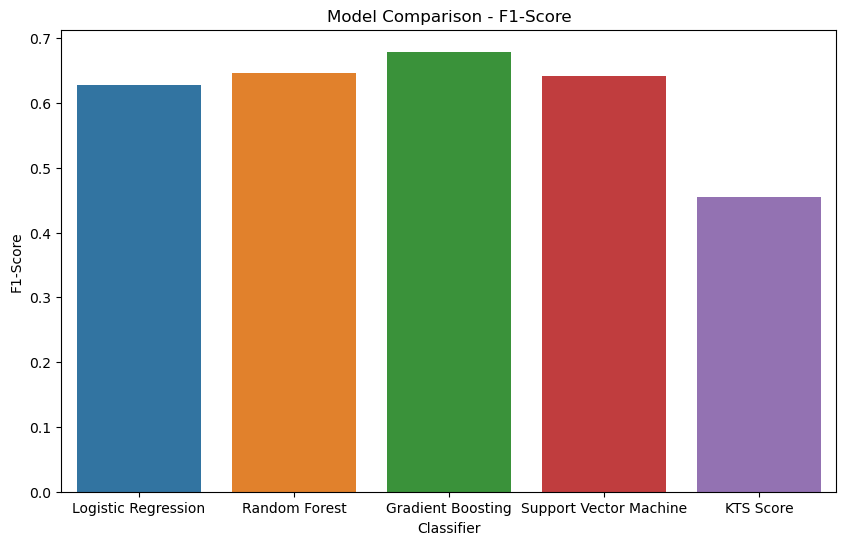

/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mikensubuga/opt/miniconda3/envs/mlamr39/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


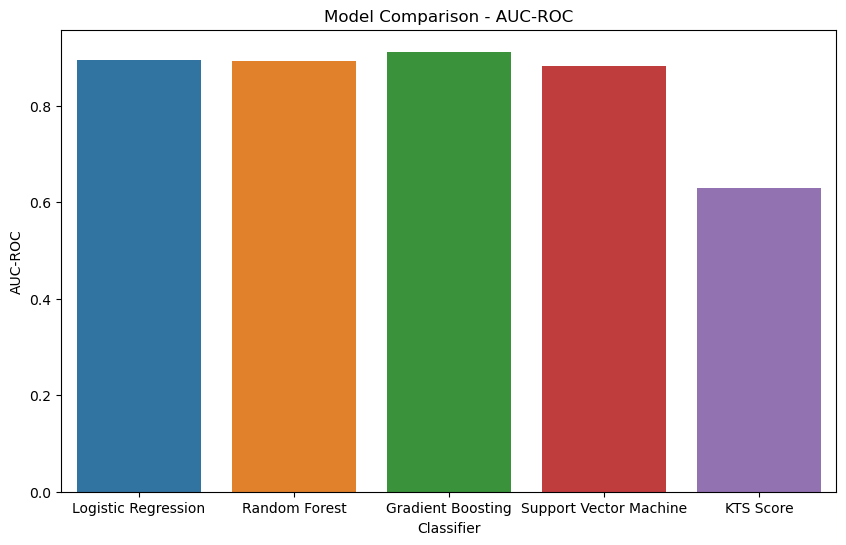

In [12]:
# Visualize Model Performance
plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='Accuracy', data=results_df)
plt.title('Model Comparison - Accuracy')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='Precision', data=results_df)
plt.title('Model Comparison - Precision')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='Recall', data=results_df)
plt.title('Model Comparison - Recall')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='F1-Score', data=results_df)
plt.title('Model Comparison - F1-Score')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='AUC-ROC', data=results_df)
plt.title('Model Comparison - AUC-ROC')
plt.show()